# Experimenting with neural networks with multiple hidden layers

## Parameter initialisation

In [14]:
# Load packages
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import OrderedDict

In [26]:
# Make neural network of given width and depth
def make_net(w, d):
#     Input layer
    od = OrderedDict([('lin1', nn.Linear(1, w)), ('relu1', nn.ReLU())])
#     Middle layers
    for l in range(d-1):
        od[f"lin{l+2}"] = nn.Linear(w, w)
        od[f"relu{l+2}"] = nn.ReLU()
#     Output
    od['out'] = nn.Linear(w, 1)
    
    return od

In [27]:
# Neural network model for given neural net
class NeuralNetwork(nn.Module):
    def __init__(self, net):
        super(NeuralNetwork, self).__init__()
        self.seq_modules = nn.Sequential(net)

    def forward(self, x):
        logits = self.seq_modules(x)
        return logits

In [46]:
# Plot initial predictions of given number of neural nets of given depth and range of widths
# over range of one-D input values
def plot_samps(d, n_s):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 2))
    ax = [ax1, ax2, ax3]
    for i in range(n_s):
        for j in range(3):
            net = make_net(2**(j+1), d)
            model = NeuralNetwork(net)
            X = torch.linspace(-2, 2, 101).reshape((101, 1))
            y = np.array(model(X).detach())
            X = np.array(X.detach())
            ax[j].plot(X, y)
            ax[j].set_title(f"w = {2**(j+2)}, d = {d}")
#             ax[j].set_ylimit(-2, 2)
    plt.show()

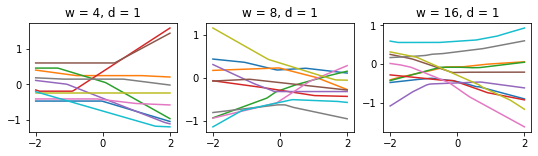

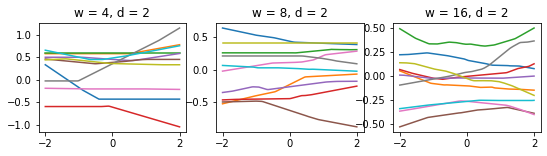

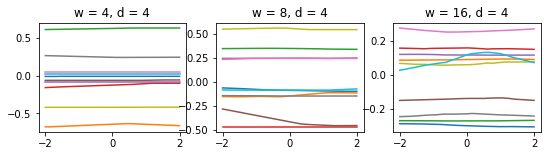

In [47]:
# Plot initial predictions of neural nets of range of widths and depths
plot_samps(d=1, n_s=10)
plot_samps(d=2, n_s=10)
plot_samps(d=4, n_s=10)

It's hard to tell without setting the range of the y-axes, but the variance of the predictions seems to decrease, and the covariance seems to increase, with depth, while width does not seem to be as important.

It seems like it should depend on the way the parameters are initialised.

The default parameter initialization for nn.Linear uses a $U\left(-\sqrt{k}, \sqrt{k}\right)$ distribution, where $k = \frac{1}{in\_features}$. So the variance of each parameter is 

$$\frac{1}{12} \left\{\sqrt{k} - \left(-\sqrt{k}\right)\right\}^2$$
$$= \frac{1}{12} \left(2 \sqrt{k}\right)^2$$
$$= \frac{k}{3},$$

which is inversely proportional to the number of input features.

For a constant input $x$, the variance of an output from the linear layer is then

$$(x^2 in\_features + 1) \frac{k}{3}$$
$$= \frac{k + x^2}{3},$$

which is $\Theta(1)$ w.r.t. the number of input features.

What happens after the ReLU?

For one input $x$, and one neuron with weight $w$, and bias $b$, the output is

$$y = \left\{
\begin{array}{ll}
      0 & w x + b \le 0 \\
      w x + b & w x + b > 0 \\
\end{array} 
\right.$$

and the variance is 

$$Var(y) = E(y^2) - E(y)^2$$

$$E(y) = P(wx + b > 0) E(wx + b|wx + b > 0)$$

$$P(wx + b > 0) = 0.5$$

by symmetry.

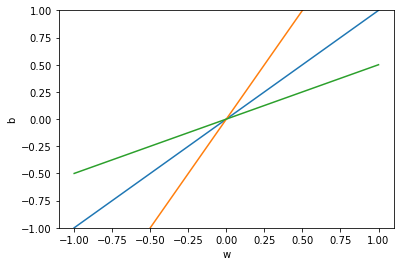

In [13]:
X = np.linspace(-1, 1, 101).reshape((101, 1))
plt.plot(X, X)
plt.plot(X, 2*X)
plt.plot(X, X/2)
plt.xlabel("w")
plt.ylabel("b")
plt.ylim(-1, 1)
plt.show()

$$w x + b > 0$$
$$w x > -b$$
$$w > \frac{-b}{x}, x > 0$$
$$w < \frac{-b}{x}, x < 0$$

$$E(w x + b|w x + b > 0) = \frac{f(wx + b)}{f(1)},$$

$$f(x') = \left\{
\begin{array}{ll}
      \int_{-\sqrt{k}}^{\sqrt{k}} \int_{-\sqrt{k}}^{-bx^{-1}} x' dwdb & x < -1 \\
      \int_{-\sqrt{k}}^{\sqrt{k}} \int_{wx^{-1}}^{\sqrt{k}} x' dbdw & -1 < x < 0, 0 < x < 1 \\
      \int_0^{\sqrt{k}} x' db & x = 0 \\
      \int_{-\sqrt{k}}^{\sqrt{k}} \int_{-bx^{-1}}^{\sqrt{k}} x' dwdb & x > 1 \\
\end{array} 
\right.$$

$$\int_{-\sqrt{k}}^{\sqrt{k}} \int_{-\sqrt{k}}^{-bx^{-1}} (wx + b) dwdb = \int_{-\sqrt{k}}^{\sqrt{k}} \left(\frac{w^2 x}{2} + bw\right)\Bigg|_{-\sqrt{k}}^{-bx^{-1}} db $$

$$= \int_{-\sqrt{k}}^{\sqrt{k}} \left(\frac{-b^2 x^{-1}}{2} - b^2 x^{-1} + \frac{kx}{2} + b\sqrt{k}\right) db$$

$$= \int_{-\sqrt{k}}^{\sqrt{k}} \left(\frac{-3b^2 x^{-1}}{2} + b\sqrt{k} + \frac{kx}{2} \right) db$$

$$= \left(\frac{-b^3 x^{-1}}{2} + \frac{b^2\sqrt{k}}{2} + \frac{kxb}{2} \right) \Bigg|_{-\sqrt{k}}^{\sqrt{k}}$$

$$= \frac{-k^{\frac{3}{2}} x^{-1}}{2} + \frac{k^{\frac{3}{2}}}{2} + \frac{k^{\frac{3}{2}}x}{2} - \frac{k^{\frac{3}{2}} x^{-1}}{2} - \frac{k^{\frac{3}{2}}}{2} + \frac{k^{\frac{3}{2}}x}{2}$$

$$= k^{\frac{3}{2}} (x - x^{-1})$$

$$\int_{-\sqrt{k}}^{\sqrt{k}} \int_{-\sqrt{k}}^{-bx^{-1}} dwdb = \int_{-\sqrt{k}}^{\sqrt{k}} w \Bigg|_{-\sqrt{k}}^{-bx^{-1}} db $$

$$= \int_{-\sqrt{k}}^{\sqrt{k}} \left(-bx^{-1} + \sqrt{k} \right) db $$

$$= \left(\frac{-b^2x^{-1}}{2} + \sqrt{k}b \right) \Bigg|_{-\sqrt{k}}^{\sqrt{k}} $$

$$= \frac{-kx^{-1}}{2} + k + \frac{kx^{-1}}{2} + k$$

$$= 2k$$ 

$$E(w x + b|w x + b > 0) = \frac{k^{\frac{3}{2}} (x - x^{-1})}{2k}, x < -1$$

$$= \frac{\sqrt{k} (x - x^{-1})}{2}$$

$$E(y) = 0.5 \frac{\sqrt{k} (x - x^{-1})}{2}, x < -1$$

$$= \frac{\sqrt{k} (x - x^{-1})}{4}$$

$$E(y^2) = P(wx + b > 0) E((wx + b)^2|wx + b > 0)$$

$$E((wx + b)^2|wx + b > 0) = \frac{f((wx + b)^2)}{f(1)}$$

$$\int_{-\sqrt{k}}^{\sqrt{k}} \int_{-\sqrt{k}}^{-bx^{-1}} (wx + b)^2 dwdb = \int_{-\sqrt{k}}^{\sqrt{k}} \int_{-\sqrt{k}x + b}^0 u^2 x^{-1} dudb$$

$$= \int_{-\sqrt{k}}^{\sqrt{k}} \frac{u^3}{3} \Bigg|_{-\sqrt{k}x + b}^0 x^{-1} db$$

$$= \int_{-\sqrt{k}}^{\sqrt{k}} -\frac{(-\sqrt{k}x + b)^3}{3} x^{-1} db$$

$$= \int_{-\sqrt{k}(x + 1)}^{\sqrt{k}(1 - x)} -\frac{u^3}{3} x^{-1} du$$

$$= -\frac{u^4}{12} \Bigg|_{-\sqrt{k}(x + 1)}^{\sqrt{k}(1 - x)} x^{-1}$$

$$= \left(-\frac{k^2 (1 - x)^4}{12} + \frac{k^2(x + 1)^4}{12} \right)x^{-1}$$

$$= k^2 \left(\frac{x^4 + 4x^3 + 6x^2 + 4x + 1 - (x^4 - 4x^3 + 6x^2 - 4x + 1)}{12} \right) x^{-1}$$

$$= 2k^2 \left(\frac{x^2 + 1}{3} \right)$$

$$E(y^2) = \frac{1}{2} 2k^2 \left(\frac{x^2 + 1}{3} \right), x < -1$$

$$= k^2 \left(\frac{x^2 + 1}{3} \right)$$

$$Var(y) = k^2 \left(\frac{x^2 + 1}{3} \right) - \left(\frac{\sqrt{k} (x - x^{-1})}{4}\right)^2$$

$$Var(y) = k^2 \left(\frac{x^2 + 1}{3} \right) - \frac{k (x - x^{-1})^2}{16}, x < -1$$

which is inversely proportional to in_features.

$$E\{(wx + b)^2\} = E(w^2 x^2) + E(2wx) + E(b^2)$$

$$= x^2 E(w^2) + 2x E(w) + E(b^2)$$

$$= x^2 Var(w) + Var(b)$$

$$= (x^2 + 1) \frac{k}{3}$$

for the parameter intialisation above.

$$= \int y^2 f(y) dy - \left(\int y f(y) dy\right)^2$$
$$= \int_{wx + b > 0} (wx + b)^2 f(wx + b) d(wx + b) - \left(\int_{wx + b > 0} (wx + b) f(wx + b) d(wx + b)\right)^2$$

$$= $$



$$= \int_{-\sqrt{k}}^{\sqrt{k}} \int (wx + b)^2 f(wx + b) \frac{dy}{dw} \frac{dy}{db} dw db - \left(\int \int y f(w) f(b) dw db\right)^2$$

$$f(y) = \frac{dF(y)}{dy} = \frac{dF(wx + b)}{d(wx + b)} = $$


...  Anyway it seems like it normalises it somehow, so that the variance of each function point is constant over width and depth, but the covariance of nearby points increases with depth (the length-scale of the covariance function increases).